In [19]:
import json
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from matplotlib.colors import to_rgba
from shapely.geometry import Point, Polygon
from sklearn import preprocessing
from sklearn.cluster import KMeans,DBSCAN
from pylab import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import griddata
from scipy import interpolate
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn import metrics
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Activation
from keras import optimizers
from keras.layers import Dropout
import tsfresh
from tsfresh.utilities.dataframe_functions import roll_time_series

In [20]:
# import telecommunication data for trentino area
df_telcom_raw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KPMG_Assignment/data/Internet_traffic_activity.csv',header=None)  
# change column names to meaningful values
df_telcom_raw.columns =['Square_id','Timestamp','Internet_traffic_activity']
# copy raw data to processed (copies only the reference to the object) 
df_telcom_processed = df_telcom_raw.copy()
# drop duplicates found in the dataset
df_telcom_processed.drop_duplicates(inplace=True)
# convert timestamp column to datetime type
df_telcom_processed.Timestamp = pd.to_datetime(df_telcom_processed.Timestamp, format='%Y-%m-%d %H:%M')
# remove outliers
df_telcom_processed = df_telcom_processed[df_telcom_processed.Internet_traffic_activity < 1000]
df_telcom_processed = df_telcom_processed[np.abs(df_telcom_processed.Internet_traffic_activity-df_telcom_processed.Internet_traffic_activity.mean()) <= (2*df_telcom_processed.Internet_traffic_activity.std())]
print(df_telcom_processed.dtypes)
df_telcom_processed

Square_id                             int64
Timestamp                    datetime64[ns]
Internet_traffic_activity           float64
dtype: object


,Square_id,Timestamp,Internet_traffic_activity
0,10000,2013-12-01 00:00:00,9.381368
1,10000,2013-12-01 01:00:00,11.966050
2,10000,2013-12-01 02:00:00,10.588980
3,10000,2013-12-01 03:00:00,8.662089
4,10000,2013-12-01 04:00:00,7.491499
...,...,...,...
4646414,9999,2013-12-31 19:00:00,33.811344
4646415,9999,2013-12-31 20:00:00,32.427682
4646416,9999,2013-12-31 21:00:00,34.441008
4646417,9999,2013-12-31 22:00:00,32.575771


In [21]:
# create temporal fields based on date and time
df_telcom_temporal = df_telcom_processed.copy()
df_telcom_temporal.loc[:,'Date'] = df_telcom_temporal.Timestamp.dt.date
df_telcom_temporal.loc[:,'Time'] = df_telcom_temporal.Timestamp.dt.time
df_telcom_temporal.loc[:,'Year'] = df_telcom_temporal.Timestamp.dt.year
df_telcom_temporal.loc[:,'Month'] = df_telcom_temporal.Timestamp.dt.month
df_telcom_temporal.loc[:,'day'] = df_telcom_temporal.Timestamp.dt.day
df_telcom_temporal.loc[:,'Quarter'] = df_telcom_temporal.Timestamp.dt.quarter
df_telcom_temporal.loc[:,'Weekday'] = df_telcom_temporal.Timestamp.dt.weekday
df_telcom_temporal.loc[:,'Hour'] = df_telcom_temporal.Timestamp.dt.hour

# remove outliers more than 3sd
# df_telcom_temporal = df_telcom_temporal[np.abs(df_telcom_temporal.Internet_traffic_activity-df_telcom_temporal.Internet_traffic_activity.mean()) <= (df_telcom_temporal.Internet_traffic_activity.std())]
df_telcom_temporal

,Square_id,Timestamp,Internet_traffic_activity,Date,Time,Year,Month,day,Quarter,Weekday,Hour
0,10000,2013-12-01 00:00:00,9.381368,2013-12-01,00:00:00,2013,12,1,4,6,0
1,10000,2013-12-01 01:00:00,11.966050,2013-12-01,01:00:00,2013,12,1,4,6,1
2,10000,2013-12-01 02:00:00,10.588980,2013-12-01,02:00:00,2013,12,1,4,6,2
3,10000,2013-12-01 03:00:00,8.662089,2013-12-01,03:00:00,2013,12,1,4,6,3
4,10000,2013-12-01 04:00:00,7.491499,2013-12-01,04:00:00,2013,12,1,4,6,4
...,...,...,...,...,...,...,...,...,...,...,...
4646414,9999,2013-12-31 19:00:00,33.811344,2013-12-31,19:00:00,2013,12,31,4,1,19
4646415,9999,2013-12-31 20:00:00,32.427682,2013-12-31,20:00:00,2013,12,31,4,1,20
4646416,9999,2013-12-31 21:00:00,34.441008,2013-12-31,21:00:00,2013,12,31,4,1,21
4646417,9999,2013-12-31 22:00:00,32.575771,2013-12-31,22:00:00,2013,12,31,4,1,22


In [22]:
df_telcom_temporal.describe()

,Square_id,Internet_traffic_activity,Year,Month,day,Quarter,Weekday,Hour
count,4.521326e+06,4.521326e+06,4521326.0,4521326.0,4.521326e+06,4521326.0,4.521326e+06,4.521326e+06
mean,6.084231e+03,1.232408e+01,2013.0,12.0,1.593288e+01,4.0,2.934770e+00,1.143214e+01
std,2.607153e+03,1.425475e+01,0.0,0.0,8.915171e+00,0.0,2.076723e+00,6.938746e+00
min,3.800000e+01,5.836761e-06,2013.0,12.0,1.000000e+00,4.0,0.000000e+00,0.000000e+00
25%,4.142000e+03,2.765042e+00,2013.0,12.0,8.000000e+00,4.0,1.000000e+00,5.000000e+00
50%,6.237000e+03,7.325408e+00,2013.0,12.0,1.600000e+01,4.0,3.000000e+00,1.100000e+01
75%,8.128000e+03,1.614315e+01,2013.0,12.0,2.400000e+01,4.0,5.000000e+00,1.700000e+01
max,1.145400e+04,8.111605e+01,2013.0,12.0,3.100000e+01,4.0,6.000000e+00,2.300000e+01


In [23]:
# compute the average hourly internet traffic
df_internet_hourly_LUT = df_telcom_temporal.groupby(['Hour'])['Internet_traffic_activity'].mean()
df_internet_hourly_LUT = pd.DataFrame({'Internet_traffic_hourly':df_internet_hourly_LUT})
df_processed_tmp = pd.merge(df_telcom_temporal,df_internet_hourly_LUT,how='left',on='Hour')

# compute the average internet traffic per weekday
df_internet_weekday_LUT = df_processed_tmp.groupby(['Weekday'])['Internet_traffic_activity'].mean()
df_internet_weekday_LUT = pd.DataFrame({'Internet_traffic_weekday':df_internet_weekday_LUT})
df_processed = pd.merge(df_processed_tmp,df_internet_weekday_LUT,how='left',on='Weekday')



In [24]:
df_univariate = df_processed.groupby(['Timestamp'])['Internet_traffic_activity'].mean()
y = pd.DataFrame({'Internet_traffic_activity_timestamp' : df_univariate.values})

X = df_processed.drop(['Square_id','Internet_traffic_activity'],axis = 1)
X.drop_duplicates(inplace=True)

# add trend and id
X.loc[:,'Trend'] = np.arange(0,len(X))
X.loc[:,'id'] = 1
X


,Timestamp,Date,Time,Year,Month,day,Quarter,Weekday,Hour,Internet_traffic_hourly,Internet_traffic_weekday,Trend,id
0,2013-12-01 00:00:00,2013-12-01,00:00:00,2013,12,1,4,6,0,10.699110,13.292944,0,1
1,2013-12-01 01:00:00,2013-12-01,01:00:00,2013,12,1,4,6,1,9.355247,13.292944,1,1
2,2013-12-01 02:00:00,2013-12-01,02:00:00,2013,12,1,4,6,2,8.448677,13.292944,2,1
3,2013-12-01 03:00:00,2013-12-01,03:00:00,2013,12,1,4,6,3,7.968245,13.292944,3,1
4,2013-12-01 04:00:00,2013-12-01,04:00:00,2013,12,1,4,6,4,7.740748,13.292944,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4380203,2013-12-31 19:00:00,2013-12-31,19:00:00,2013,12,31,4,1,19,14.578009,12.373957,739,1
4380204,2013-12-31 20:00:00,2013-12-31,20:00:00,2013,12,31,4,1,20,14.351004,12.373957,740,1
4380205,2013-12-31 21:00:00,2013-12-31,21:00:00,2013,12,31,4,1,21,14.054845,12.373957,741,1
4380206,2013-12-31 22:00:00,2013-12-31,22:00:00,2013,12,31,4,1,22,13.324658,12.373957,742,1


In [25]:
# prepare features and target variable
X = X.drop(['Timestamp','Date','Time','Internet_traffic_hourly','Internet_traffic_weekday'],axis=1)
X



,Year,Month,day,Quarter,Weekday,Hour,Trend,id
0,2013,12,1,4,6,0,0,1
1,2013,12,1,4,6,1,1,1
2,2013,12,1,4,6,2,2,1
3,2013,12,1,4,6,3,3,1
4,2013,12,1,4,6,4,4,1
...,...,...,...,...,...,...,...,...
4380203,2013,12,31,4,1,19,739,1
4380204,2013,12,31,4,1,20,740,1
4380205,2013,12,31,4,1,21,741,1
4380206,2013,12,31,4,1,22,742,1


In [26]:
# extract features based on the shape of timeseries e.g. Calculates the highest absolute value of the time series x, Returns the sum over the absolute value of consecutive changes in the series x etc.
results = tsfresh.extract_relevant_features(X, y['Internet_traffic_activity_timestamp'],column_id='Trend', column_sort='Trend')  ##, default_fc_parameters=tsfresh.feature_extraction.MinimalFCParameters())  # Extract minimum parameters for memory management
results

Feature Extraction: 100%|██████████| 5/5 [02:39<00:00, 31.84s/it]


,Hour__abs_energy,"Hour__fft_coefficient__attr_""real""__coeff_0","Hour__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","Hour__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","Hour__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","Hour__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)",Hour__quantile__q_0.9,Hour__quantile__q_0.8,Hour__quantile__q_0.7,"Hour__fft_coefficient__attr_""abs""__coeff_0",Hour__quantile__q_0.6,Hour__quantile__q_0.3,Hour__quantile__q_0.2,Hour__quantile__q_0.1,Hour__minimum,Hour__maximum,Hour__root_mean_square,Hour__mean,Hour__median,Hour__quantile__q_0.4,Hour__sum_values,day__sum_values,"day__fft_coefficient__attr_""real""__coeff_0",day__abs_energy,day__median,day__mean,day__root_mean_square,day__maximum,day__minimum,day__quantile__q_0.1,day__quantile__q_0.2,"day__fft_coefficient__attr_""abs""__coeff_0",day__quantile__q_0.3,day__quantile__q_0.6,day__quantile__q_0.7,day__quantile__q_0.8,day__quantile__q_0.9,"day__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)","day__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","day__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","day__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)",day__quantile__q_0.4,Hour__benford_correlation,Hour__value_count__value_1,Weekday__benford_correlation,day__benford_correlation,Weekday__quantile__q_0.9,"Weekday__fft_coefficient__attr_""real""__coeff_0",Weekday__sum_values,Weekday__abs_energy,Weekday__median,Weekday__mean,Weekday__root_mean_square,Weekday__maximum,"Weekday__fft_coefficient__attr_""abs""__coeff_0",Weekday__quantile__q_0.1,Weekday__quantile__q_0.2,Weekday__minimum,Weekday__quantile__q_0.4,Weekday__quantile__q_0.6,Weekday__quantile__q_0.7,Weekday__quantile__q_0.8,"Weekday__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","Weekday__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)","Weekday__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","Weekday__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)",Weekday__quantile__q_0.3,Hour__value_count__value_0,Hour__count_below__t_0,Hour__range_count__max_1__min_-1
0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.613291,0.387880,0.274272,0.193940,1.0,0.295657,0.0,-0.200946,0.864123,6.0,6.0,6.0,36.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,1.163639,3.679749,2.327277,1.645634,6.0,1.0,1.0,1.0
1,1.0,1.0,0.193940,0.274272,0.387880,0.613291,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.613291,0.387880,0.274272,0.193940,1.0,0.864123,1.0,-0.200946,0.864123,6.0,6.0,6.0,36.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,1.163639,3.679749,2.327277,1.645634,6.0,0.0,0.0,0.0
2,4.0,2.0,0.387880,0.548545,0.775759,1.226583,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.613291,0.387880,0.274272,0.193940,1.0,0.295657,0.0,-0.200946,0.864123,6.0,6.0,6.0,36.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,1.163639,3.679749,2.327277,1.645634,6.0,0.0,0.0,0.0
3,9.0,3.0,0.581819,0.822817,1.163639,1.839874,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.613291,0.387880,0.274272,0.193940,1.0,0.062915,0.0,-0.200946,0.864123,6.0,6.0,6.0,36.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,1.163639,3.679749,2.327277,1.645634,6.0,0.0,0.0,0.0
4,16.0,4.0,0.775759,1.097089,1.551518,2.453166,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.613291,0.387880,0.274272,0.193940,1.0,-0.064614,0.0,-0.200946,0.864123,6.0,6.0,6.0,36.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,1.163639,3.679749,2.327277,1.645634,6.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [27]:
X_tsfresh = pd.concat([X.reset_index(drop=True), results], axis=1)
X_tsfresh

,Year,Month,day,Quarter,Weekday,Hour,Trend,id,Hour__abs_energy,"Hour__fft_coefficient__attr_""real""__coeff_0","Hour__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","Hour__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","Hour__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","Hour__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)",Hour__quantile__q_0.9,Hour__quantile__q_0.8,Hour__quantile__q_0.7,"Hour__fft_coefficient__attr_""abs""__coeff_0",Hour__quantile__q_0.6,Hour__quantile__q_0.3,Hour__quantile__q_0.2,Hour__quantile__q_0.1,Hour__minimum,Hour__maximum,Hour__root_mean_square,Hour__mean,Hour__median,Hour__quantile__q_0.4,Hour__sum_values,day__sum_values,"day__fft_coefficient__attr_""real""__coeff_0",day__abs_energy,day__median,day__mean,day__root_mean_square,day__maximum,day__minimum,day__quantile__q_0.1,day__quantile__q_0.2,"day__fft_coefficient__attr_""abs""__coeff_0",day__quantile__q_0.3,day__quantile__q_0.6,day__quantile__q_0.7,day__quantile__q_0.8,day__quantile__q_0.9,"day__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)","day__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","day__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","day__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)",day__quantile__q_0.4,Hour__benford_correlation,Hour__value_count__value_1,Weekday__benford_correlation,day__benford_correlation,Weekday__quantile__q_0.9,"Weekday__fft_coefficient__attr_""real""__coeff_0",Weekday__sum_values,Weekday__abs_energy,Weekday__median,Weekday__mean,Weekday__root_mean_square,Weekday__maximum,"Weekday__fft_coefficient__attr_""abs""__coeff_0",Weekday__quantile__q_0.1,Weekday__quantile__q_0.2,Weekday__minimum,Weekday__quantile__q_0.4,Weekday__quantile__q_0.6,Weekday__quantile__q_0.7,Weekday__quantile__q_0.8,"Weekday__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","Weekday__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)","Weekday__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","Weekday__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)",Weekday__quantile__q_0.3,Hour__value_count__value_0,Hour__count_below__t_0,Hour__range_count__max_1__min_-1
0,2013,12,1,4,6,0,0,1,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.613291,0.387880,0.274272,0.193940,1.0,0.295657,0.0,-0.200946,0.864123,6.0,6.0,6.0,36.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,1.163639,3.679749,2.327277,1.645634,6.0,1.0,1.0,1.0
1,2013,12,1,4,6,1,1,1,1.0,1.0,0.193940,0.274272,0.387880,0.613291,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.613291,0.387880,0.274272,0.193940,1.0,0.864123,1.0,-0.200946,0.864123,6.0,6.0,6.0,36.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,1.163639,3.679749,2.327277,1.645634,6.0,0.0,0.0,0.0
2,2013,12,1,4,6,2,2,1,4.0,2.0,0.387880,0.548545,0.775759,1.226583,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.613291,0.387880,0.274272,0.193940,1.0,0.295657,0.0,-0.200946,0.864123,6.0,6.0,6.0,36.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,1.163639,3.679749,2.327277,1.645634,6.0,0.0,0.0,0.0
3,2013,12,1,4,6,3,3,1,9.0,3.0,0.581819,0.822817,1.163639,1.839874,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.613291,0.387880,0.274272,0.193940,1.0,0.062915,0.0,-0.200946,0.864123,6.0,6.0,6.0,36.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,1.163639,3.679749,2.327277,1.645634,6.0,0.0,0.0,0.0
4,2013,12,1,4,6,4,4,1,16.0,4.0,0.775759,1.097089,1.551518,2.453166,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.613291,0.387880,0.274272,0.193940,1.0,-0.064614,0.0,-0.200946,0.864123,6.0,6.0,6.0,36.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0

In [28]:
# split dataset to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tsfresh, y, test_size=0.2, shuffle=False)
X_train

,Year,Month,day,Quarter,Weekday,Hour,Trend,id,Hour__abs_energy,"Hour__fft_coefficient__attr_""real""__coeff_0","Hour__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","Hour__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","Hour__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","Hour__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)",Hour__quantile__q_0.9,Hour__quantile__q_0.8,Hour__quantile__q_0.7,"Hour__fft_coefficient__attr_""abs""__coeff_0",Hour__quantile__q_0.6,Hour__quantile__q_0.3,Hour__quantile__q_0.2,Hour__quantile__q_0.1,Hour__minimum,Hour__maximum,Hour__root_mean_square,Hour__mean,Hour__median,Hour__quantile__q_0.4,Hour__sum_values,day__sum_values,"day__fft_coefficient__attr_""real""__coeff_0",day__abs_energy,day__median,day__mean,day__root_mean_square,day__maximum,day__minimum,day__quantile__q_0.1,day__quantile__q_0.2,"day__fft_coefficient__attr_""abs""__coeff_0",day__quantile__q_0.3,day__quantile__q_0.6,day__quantile__q_0.7,day__quantile__q_0.8,day__quantile__q_0.9,"day__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)","day__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","day__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","day__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)",day__quantile__q_0.4,Hour__benford_correlation,Hour__value_count__value_1,Weekday__benford_correlation,day__benford_correlation,Weekday__quantile__q_0.9,"Weekday__fft_coefficient__attr_""real""__coeff_0",Weekday__sum_values,Weekday__abs_energy,Weekday__median,Weekday__mean,Weekday__root_mean_square,Weekday__maximum,"Weekday__fft_coefficient__attr_""abs""__coeff_0",Weekday__quantile__q_0.1,Weekday__quantile__q_0.2,Weekday__minimum,Weekday__quantile__q_0.4,Weekday__quantile__q_0.6,Weekday__quantile__q_0.7,Weekday__quantile__q_0.8,"Weekday__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","Weekday__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)","Weekday__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","Weekday__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)",Weekday__quantile__q_0.3,Hour__value_count__value_0,Hour__count_below__t_0,Hour__range_count__max_1__min_-1
0,2013,12,1,4,6,0,0,1,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.613291,0.387880,0.274272,0.193940,1.0,0.295657,0.0,-0.200946,0.864123,6.0,6.0,6.0,36.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,1.163639,3.679749,2.327277,1.645634,6.0,1.0,1.0,1.0
1,2013,12,1,4,6,1,1,1,1.0,1.0,0.193940,0.274272,0.387880,0.613291,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.613291,0.387880,0.274272,0.193940,1.0,0.864123,1.0,-0.200946,0.864123,6.0,6.0,6.0,36.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,1.163639,3.679749,2.327277,1.645634,6.0,0.0,0.0,0.0
2,2013,12,1,4,6,2,2,1,4.0,2.0,0.387880,0.548545,0.775759,1.226583,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.613291,0.387880,0.274272,0.193940,1.0,0.295657,0.0,-0.200946,0.864123,6.0,6.0,6.0,36.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,1.163639,3.679749,2.327277,1.645634,6.0,0.0,0.0,0.0
3,2013,12,1,4,6,3,3,1,9.0,3.0,0.581819,0.822817,1.163639,1.839874,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.613291,0.387880,0.274272,0.193940,1.0,0.062915,0.0,-0.200946,0.864123,6.0,6.0,6.0,36.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,1.163639,3.679749,2.327277,1.645634,6.0,0.0,0.0,0.0
4,2013,12,1,4,6,4,4,1,16.0,4.0,0.775759,1.097089,1.551518,2.453166,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.613291,0.387880,0.274272,0.193940,1.0,-0.064614,0.0,-0.200946,0.864123,6.0,6.0,6.0,36.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0

In [29]:
# scale all features
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X_train.values)
X_train_scaled = pd.DataFrame(x_scaled)
X_test_scaled = min_max_scaler.transform(X_test.values)
X_test_scaled = pd.DataFrame(X_test_scaled)
X_train_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77
0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.510567,0.0,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0
1,0.0,0.0,0.0,0.0,1.000000,0.043478,0.001684,0.0,0.001890,0.043478,0.043478,0.043478,0.043478,0.043478,0.043478,0.043478,0.043478,0.043478,0.043478,0.043478,0.043478,0.043478,0.043478,0.043478,0.043478,0.043478,0.043478,0.043478,0.043478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.000000,0.086957,0.003367,0.0,0.007561,0.086957,0.086957,0.086957,0.086957,0.086957,0.086957,0.086957,0.086957,0.086957,0.086957,0.086957,0.086957,0.086957,0.086957,0.086957,0.086957,0.086957,0.086957,0.086957,0.086957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.510567,0.0,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.000000,0.130435,0.005051,0.0,0.017013,0.130435,0.130435,0.130435,0.130435,0.130435,0.130435,0.130435,0.130435,0.130435,0.130435,0.130435,0.130435,0.130435,0.130435,0.130435,0.130435,0.130435,0.130435,0.130435,0.130435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.310183,0.0,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.000000,0.173913,0.006734,0.0,0.030246,0.173913,0.173913,0.173913,0.173913,0.173913,0.173913,0.173913,0.173913,0.173913,0.173913,0.173913,0.173913,0.173913,0.173913,0.173913,0.173913,0.173913,0.173913,0.173913,0.173913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200384,0.0,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,0.0,0.0,1.0,0.0,0.333333,0.608696,0.993266,0.0,0.370510,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.0,0.466264,0.510567,0.333333,0.333333,0.333333,0.111111,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.0,0.0,0.0
591,0.0,0.0,1.0,0.0,0.333333,0.652174,0.994949,0.0,0.425331,0.652174,0.652174,0.652174,0.652174,0.652174,0.652174,0.652174,0.652174,0

In [30]:
# reshape input to be [samples, time steps, features]
X_train_scaled = np.reshape(X_train_scaled.values, (X_train_scaled.shape[0],1 , X_train_scaled.shape[1]))
X_test_scaled = np.reshape(X_test_scaled.values, (X_test_scaled.shape[0],1 , X_test_scaled.shape[1]))


batch_size = 80
timesteps = 1
data_dim = X_train_scaled.shape[1]

In [31]:
print(X_train_scaled.shape)
print(y_train.shape)
print(X_test_scaled.shape)
print(y_test.shape)

(595, 1, 78)
(595, 1)
(149, 1, 78)
(149, 1)


In [32]:
model = Sequential()
model.add(LSTM(12, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))  # input layer that expects 1 or more samples, 50 time steps, and 2 features.
model.add(Dropout(0.4, input_shape=(X_train_scaled.shape[1],)))
model.add(Dense(4))
model.add(Dense(1))
print(model.summary())
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train_scaled, y_train, epochs=500, batch_size=batch_size, verbose=2,shuffle=False, validation_data=(X_test_scaled, y_test))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 12)                4368      
_________________________________________________________________
dropout_1 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 52        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 4,425
Trainable params: 4,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
8/8 - 3s - loss: 127.2050 - val_loss: 304.2017
Epoch 2/500
8/8 - 0s - loss: 117.4557 - val_loss: 285.1610
Epoch 3/500
8/8 - 0s - loss: 106.3599 - val_loss: 262.3378
Epoch 4/500
8/8 - 0s - loss: 93.5848 - val_loss: 236.2323
Epoch 5/50

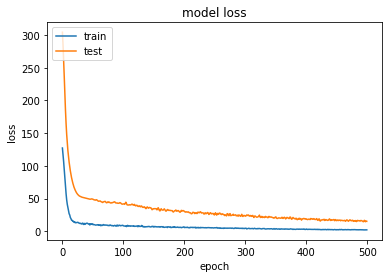

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
# make predictions
y_train_predicted = model.predict(X_train_scaled)
y_test_predicted = model.predict(X_test_scaled)

y_train_predicted = y_train_predicted.flatten()
y_test_predicted = y_test_predicted.flatten()



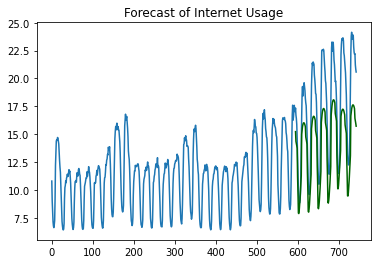

Mean Absolute Error(Train): 0.8608086253463447
R squared(Train): 0.8621286944320912
Mean Absolute Error(Test): 3.517629985162471
R squared(Test): 0.2532212955566122


In [35]:
def plot_predicted_actual_values(y_train, y_test_predicted):
  index_of_fc = np.arange(len(y_train),
                          len(y_train)+len(y_test_predicted))
  # make series for plotting purpose
  fc_series = pd.Series(y_test_predicted, index=index_of_fc)
  actual_values = np.concatenate((y.Internet_traffic_activity_timestamp.values ,y_test_predicted), axis=0)
  plt.plot(y.values)
  plt.plot(fc_series, color='darkgreen')

  plt.title("Forecast of Internet Usage")
  plt.show()

plot_predicted_actual_values(y_train, y_test_predicted)
print('Mean Absolute Error(Train):', metrics.mean_absolute_error(y_train.Internet_traffic_activity_timestamp.values,y_train_predicted))
print('R squared(Train): ' + str(metrics.r2_score(y_train.Internet_traffic_activity_timestamp.values, y_train_predicted)))
print('Mean Absolute Error(Test):', metrics.mean_absolute_error(y_test,y_test_predicted))
print('R squared(Test): ' + str(metrics.r2_score(y_test, y_test_predicted)))

Future steps:
 - Use timestep, predict 8th day for all the time-series